# The Impact of AI Chatbots on Software Engineer Productivity

## 1. Context

Software engineering is a complex system influenced by many factors, some of which are difficult to observe directly.

In a software development team, engineers interact with various tools and resources, including Generative AI chatbots, to improve their efficiency.

The causal graph below represents the key relationships affecting productivity.

![Software graph image](image.png "Causal Graph of AI Chatbot on Software Engineer Productivity")

### 1.1 **The Factors of Engineering Work**
- **X: AI Chatbot Usage**
  Use of an AI chatbot by Software Engineers to help in problem-solving.

- **Y: Productivity**
  Measurable Software Engineer's productivity.

- **D: Task Complexity**
  Software Engineer's task complexity. 

- **E: Access Management**
  Manages data access and other services in the company's software architecture.

- **F: Frustration Levels**
  Softeare Engineer frustration level.

Two **unobserved** factors influence the software engineers' work:

- **U1: Engineer Skill**  
  Each engineer has a unique skill level and faces tasks of varying complexity.
  These unobserved characteristics influence their **adoption of the AI chatbot (X)**, how they manage their time to be **productive (Y)**, and their **frustration levels (F)** when encountering obstacles.

- **U2: Organizational & Process Factors**  
  External factors, such as team structure, deadlines, and company policies, influence how tasks are assigned (**D**) and the tasks requirenments such as data privacy, microservices access (**E**).


### 1.2 **Relationships in the Graph**

- **(X → Y) AI Chatbot Usage (X) and Productivity (Y)**  
  Engineers use an AI chatbot (**X**) to accelerate problem-solving and reduce cognitive load, by providing quick answers, code suggestions, and debugging help.
  This directly influences their overall productivity (**Y**).

- **(X → D) AI Chatbot Use (X) and Task Complexity (D)**  
  Engineers dealing with more complex tasks (**D**) are more likely to turn to the AI chatbot (**X**) for assistance.

- **(D → Y) Task Complexity (D) and Productivity**  
  Complex tasks (**D**) naturally slow down engineers, reducing their productivity (**Y**).

- **(E → D) Access Management (E) and Task Complexity (D)**  
  Access management (**E**) influences the way tasks are structured and the permissions engineers have, affecting the task complexity (**D**).
  A task assigned to an engineer who does not have the appropriate permissions to access the task requirements ends up being more complex. 

### 1.3 **Intervention: Increasing AI Chatbot Usage (X)**
We intervene on **X** to encourage more engineers to use the AI chatbot.
This could be done by promoting its benefits, integrating it into workflows, or making it a required tool.
The goal is to assess whether increased chatbot adoption leads to a measurable improvement in **productivity (Y)**.

<!-- However, because **U1 (Engineer Skill)** affects both **X (chatbot use)** and **Y (productivity)**, we need to control for its influence.
Additionally, **D (task complexity)** plays a mediating role, influencing both chatbot usage and productivity. -->


### 1.4 Generate DAG Image and Input

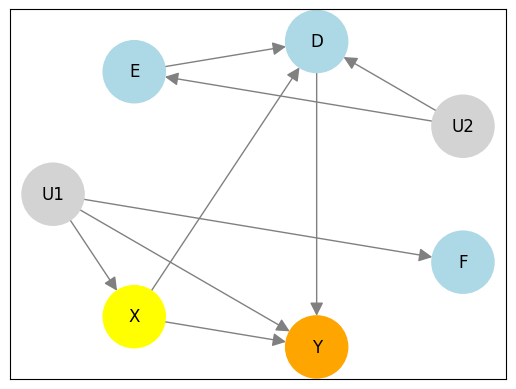

In [61]:
import os
from gurobipy import Model, GRB
import pandas as pd
import random
from typing import List, Dict, Tuple
import time

project_path = "/home/lawand/Experiments"
os.chdir(project_path)


from utils.funcoes import generate_example, get_joaos_input
from causal_solver.Helper import Helper
from causal_solver.graph import Graph
from utils.experiment import Experiment

arestas = "U1 -> X, U1 -> Y, U1 -> F, U2 -> D, U2 -> E, X -> Y, X -> D, D -> Y, E -> D"
latents = ["U1", "U2"]
intervention=["X"]
target="Y"
input_path = "/home/lawand/Experiments/Experiments/Software/software_case.txt"
generate_example(arestas, latent=latents, intervention=intervention, target=target)
get_joaos_input(edges_str=arestas, latent=latents, file_path=input_path)

## 2. Algorithm

### 2.1 Algorithm Steps

- **Initialize**: $\boldsymbol{Y_0} \gets \{Y\}$ and process the nodes in reverse topological. 
    - Process $Y$
        1. $Y$ falls under the **Case 2**
        2. Add constraint: $P(y|do(x)) = \sum_{d,u_X} P(y|D,U_X,x)P(D,U_X|do(x))$

- **$2^a$ iteration:** $\boldsymbol{Y_1} \gets \{D,U_X\}$
    - Processe $D$
        1. $D$ falls under the **Case 3** with $\boldsymbol{Z} = \varnothing$
        2. Add constraint: $P(D,U_X|do(x)) = P(D|x)P(U_X|do(x))$

 - **$3^a$ iteration:** $\boldsymbol{Y_2}\gets \{U_X\}$
 
    - Processe $U_X$
        1. $U_X$ falls under the **Case 1**
        2. Add constraint: $P(U_X|do(x)) = P(U_X)$

- **Algorithm's end:** $Y_3 \gets \varnothing$ 

### 2.2 Algorithm Optimization Problem Generated

#### 2.2.1 Constraints:

- $P(y,x,d) = \sum_{u_1}P(y|d,U_1,x)P(x|U_1)P(d|U_1)P(U_1)$

#### 2.2.2 Objective Function:

- $P(y|do(x)) = \sum_{d,u_1} P(y|D,U_1,x)P(D|x)P(U_1)$


The only unobserved probability is $P(U_1)$, hence the number of the variables in the optimization problem is -- at maximum -- the cardinality of U1.

The variables are only multiplied by constants and not by other variables, therefore the previous equations are **linear**.

## 3. Requirements

### 3.1 Code Requirements

In [62]:
test_name = "software_case"
input_path = "/home/lawand/Experiments/Experiments/Software/software_case.txt"
# input_path = "/full_path/to/Experiments/Experiments/Software/software_case.txt"
dag: Graph = Graph.parse(file_path=input_path)
csv_path = "./Experiments/Software/software_case.csv"
doX0 = 0
doX1 = 1
y_target_value = 1

### 3.2 Probability Distribution Generation

In [63]:
random.seed(42)
SAMPLES = 100_000

U1_cardinality = 32
U2_cardinality = 8
X_cardinality = 2
Y_cardinality = 2
D_cardinality = 2
E_cardinality = 2
F_cardinality = 2

def func_U1_U2(u1_0=0.5, u1_1=0.5, u2_0=0.5, u2_1=0.5):
    U1_column = random.choices([0,1], weights=[u1_0, u1_1], k=SAMPLES)
    U2_column = random.choices([0,1], weights=[u2_0, u2_1], k=SAMPLES)
    return U1_column, U2_column

def func_F(parent): # u1
    funcf = []
    for p in parent:
        funcf.append(1 if not p else 0)
    return funcf

def func_E(parent): #u2
    funce = []
    for p in parent:
        funce.append(p)
    return funce

def func_X(parent): # u1
    funcx = []
    for p in parent:
            funcx.append(p)
    return funcx

def func_D(parents): # u2, e, x
    funcd = []
    for i in range(SAMPLES):
            u2 = parents[0][i]
            e = parents[1][i]
            x = parents[2][i]
            funcd.append(1 if (e or u2) ^ x else 0)
    return funcd


def func_Y(parents): # u1, x, d
    y = []
    for i in range(SAMPLES):
            u1 = parents[0][i]
            x = parents[1][i]
            d = parents[2][i]
            y.append(1 if (u1 or x) ^ d else 0)
    return y

### 3.3 Latents Mechanisms Generator

In [64]:
_,_,u1_mechanisms = Helper.mechanisms_generator(latentNode=dag.labelToIndex["U1"], endogenousNodes=[dag.labelToIndex["X"],dag.labelToIndex["Y"]],
                                        cardinalities=dag.cardinalities,graphNodes=dag.graphNodes,v=False)

### 3.4 Useful Functions

#### 3.4.1 Set Constraints Code

In [65]:
def set_constraints(experiment: Experiment, dag: Graph, Y_cardinality, X_cardinality, D_cardinality, U1_cardinality, u1_mechanisms):
    yxdRealization : dict[int, int] = {}
    xRealization : dict[int, int] = {}
    dRealization : dict[int, int] = {}
    for y in range(Y_cardinality):
        for x in range(X_cardinality):
            for d in range(D_cardinality):
                yxdRealization[dag.labelToIndex["Y"]] = y
                yxdRealization[dag.labelToIndex["X"]] = x
                yxdRealization[dag.labelToIndex["D"]] = d
                xRealization[dag.labelToIndex["X"]] = x
                dRealization[dag.labelToIndex["D"]] = d
                expression_doX0_model_max = 0
                coef_dox0_model_max = Helper.findConditionalProbability(dataFrame=experiment.df, indexToLabel= dag.indexToLabel, targetRealization= dRealization, conditionRealization= xRealization, v=False)
                expression_doX0_model_min = 0
                coef_dox0_model_min = Helper.findConditionalProbability(dataFrame=experiment.df, indexToLabel= dag.indexToLabel, targetRealization= dRealization, conditionRealization= xRealization, v=False)

                expression_doX1_model_max = 0
                coef_dox1_model_max = Helper.findConditionalProbability(dataFrame=experiment.df, indexToLabel= dag.indexToLabel, targetRealization= dRealization, conditionRealization= xRealization, v=False)
                expression_doX1_model_min = 0
                coef_dox1_model_min = Helper.findConditionalProbability(dataFrame=experiment.df, indexToLabel= dag.indexToLabel, targetRealization= dRealization, conditionRealization= xRealization, v=False)
                for u in range(len(u1_mechanisms)):
                    if (u1_mechanisms[u][str(dag.labelToIndex["X"])+"="+str(x)+","+str(dag.labelToIndex["D"])+"="+str(d)] == y) and (u1_mechanisms[u][""] == x):
                        expression_doX0_model_max += coef_dox0_model_max*experiment.doX0_models.vars_model_max[u]
                        expression_doX0_model_min += coef_dox0_model_min*experiment.doX0_models.vars_model_min[u]
                        
                        expression_doX1_model_max += coef_dox1_model_max*experiment.doX1_models.vars_model_max[u]
                        expression_doX1_model_min += coef_dox1_model_min*experiment.doX1_models.vars_model_min[u]
                empirical = Helper.findProbability(dataFrame=experiment.df, indexToLabel= dag.indexToLabel, variableRealizations=yxdRealization, v=False)
                experiment.doX0_models.model_max.addConstr(expression_doX0_model_max == empirical, name=f"constraint_u1_y:{y}_x:{x}_d:{d}")
                experiment.doX0_models.model_min.addConstr(expression_doX0_model_min == empirical, name=f"constraint_u1_y:{y}_x:{x}_d:{d}")
                experiment.doX1_models.model_max.addConstr(expression_doX1_model_max == empirical, name=f"constraint_u1_y:{y}_x:{x}_d:{d}")
                experiment.doX1_models.model_min.addConstr(expression_doX1_model_min == empirical, name=f"constraint_u1_y:{y}_x:{x}_d:{d}")

    expression_doX0_model_max = 0
    expression_doX0_model_min = 0
    expression_doX1_model_max = 0
    expression_doX1_model_min = 0
    for u in range(U1_cardinality):
        expression_doX0_model_max += experiment.doX0_models.vars_model_max[u]
        expression_doX0_model_min += experiment.doX0_models.vars_model_min[u]
        expression_doX1_model_max += experiment.doX1_models.vars_model_max[u]
        expression_doX1_model_min += experiment.doX1_models.vars_model_min[u]
    experiment.doX0_models.model_max.addConstr(expression_doX0_model_max == 1.0, name=f"constraint_Total_U1")
    experiment.doX0_models.model_min.addConstr(expression_doX0_model_min == 1.0, name=f"constraint_Total_U1")
    experiment.doX1_models.model_max.addConstr(expression_doX1_model_max == 1.0, name=f"constraint_Total_U1")
    experiment.doX1_models.model_min.addConstr(expression_doX1_model_min == 1.0, name=f"constraint_Total_U1")

#### 3.4.2 Set Objective Function Code

In [66]:
def set_objective_function(experiment: Experiment, dag: Graph, y_target_value, u1_mechanisms, D_cardinality, doX0, doX1):
    xRealization : dict[int, int] = {}
    yRealization : dict[int, int] = {}
    dRealization : dict[int, int] = {}

    yRealization[dag.labelToIndex["Y"]] = y_target_value
    expression_doX0_model_max = 0
    expression_doX0_model_min = 0
    expression_doX1_model_max = 0
    expression_doX1_model_min = 0
    for u in range(len(u1_mechanisms)):
        coef_dox0_model_max = 0
        coef_dox0_model_min = 0
        coef_dox1_model_max = 0
        coef_dox1_model_min = 0
        for d in range(D_cardinality):
            dRealization[dag.labelToIndex["D"]] = d
            
            xRealization[dag.labelToIndex["X"]] = doX0
            if u1_mechanisms[u][str(dag.labelToIndex["X"])+"="+str(doX0)+","+str(dag.labelToIndex["D"])+"="+str(d)] == y_target_value:
                coef_dox0_model_max += Helper.findConditionalProbability(dataFrame=experiment.df, indexToLabel= dag.indexToLabel, targetRealization=dRealization, conditionRealization= xRealization)
                coef_dox0_model_min += Helper.findConditionalProbability(dataFrame=experiment.df, indexToLabel= dag.indexToLabel, targetRealization=dRealization, conditionRealization= xRealization)
            
            xRealization[dag.labelToIndex["X"]] = doX1
            if u1_mechanisms[u][str(dag.labelToIndex["X"])+"="+str(doX1)+","+str(dag.labelToIndex["D"])+"="+str(d)] == y_target_value:
                coef_dox1_model_max += Helper.findConditionalProbability(dataFrame=experiment.df, indexToLabel= dag.indexToLabel, targetRealization=dRealization, conditionRealization= xRealization)
                coef_dox1_model_min += Helper.findConditionalProbability(dataFrame=experiment.df, indexToLabel= dag.indexToLabel, targetRealization=dRealization, conditionRealization= xRealization)
        
        expression_doX0_model_max += coef_dox0_model_max*experiment.doX0_models.vars_model_max[u]
        expression_doX0_model_min += coef_dox0_model_min*experiment.doX0_models.vars_model_min[u]
        expression_doX1_model_max += coef_dox1_model_max*experiment.doX1_models.vars_model_max[u]
        expression_doX1_model_min += coef_dox1_model_min*experiment.doX1_models.vars_model_min[u]

    experiment.doX0_models.model_max.setObjective(expression_doX0_model_max, GRB.MAXIMIZE)
    experiment.doX0_models.model_min.setObjective(expression_doX0_model_min, GRB.MINIMIZE)
    experiment.doX1_models.model_max.setObjective(expression_doX1_model_max, GRB.MAXIMIZE)
    experiment.doX1_models.model_min.setObjective(expression_doX1_model_min, GRB.MINIMIZE)

#### 3.4.3 Get Groundtruth

In [67]:
def get_groundtruth(dag: Graph, dataframe, y_target_value, doX) -> float:
    xuRealization = {}
    yRealization = {}
    uRealization = {}

    yRealization[dag.labelToIndex["Y"]] = y_target_value
    xuRealization[dag.labelToIndex["X"]] = doX
    prob_y_doX = 0
    for u in [0,1]:
        uRealization[dag.labelToIndex["U1"]] = u
        xuRealization[dag.labelToIndex["U1"]] = u
        p = Helper.findConditionalProbability(dataFrame=dataframe,
                                              indexToLabel=dag.indexToLabel,
                                              targetRealization=yRealization,
                                              conditionRealization=xuRealization,
                                              v=False
        )
        pu = Helper.findProbability(dataFrame=dataframe,
                                    indexToLabel=dag.indexToLabel,
                                    variableRealizations=uRealization,
                                    v=False
        )
        prob_y_doX += p*pu
    return prob_y_doX

## 4. Robustness Test

### 4.1 Introduction

For the robustness test, a dataset of 100,000 data is generated following a probability distribution of the exogenous (latent) variables $\big( U_1 = \{0, 1\}$, $P(U_1 = 0) = 0.5 \big)$, $ \big(U_2 = \{0, 1\}$, $P(U_2 = 0) = 0.5 \big)$ and the endogenous functions defined previously (section 3.2).

Seven experiments will be carried out, each taking a subset of the data from this dataset.
The experiments will have the following amounts of data: 100,000, 50,000, 10,000, 5,000, 1,000, 500 and 100.
With these seven datasets, each experiment consists of running the Gurobi polynomial solver for the optimization problem (section 2.2) using the empirical probabilities taken from the experiment's dataset.


### 4.2 Experiments Object Creation

In [68]:
robustness_experiments : List[Experiment] = []

U1, U2 = func_U1_U2()
F = func_F(U1)
E = func_E(U2)
X = func_X(U1)
D = func_D([U2, E, X])
Y = func_Y([U1, X, D])

df_100k_with_latents = pd.DataFrame({
    "U1": U1,
    "U2": U2,
    "F": F,
    "E": E,
    "D": D,
    "X": X,
    "Y": Y,
})

df_100k = pd.DataFrame({
    "F": F,
    "E": E,
    "D": D,
    "X": X,
    "Y": Y,
})
df_100k.to_csv(csv_path, index=False)

rows_quantity = [
    100_000,
    50_000,
    10_000,
    5_000,
    1_000,
    500,
    100,
]

for quantity in rows_quantity:
    robustness_experiments.append(
        Experiment(
            df_100k.iloc[:quantity],
            doX0_groundtruth=get_groundtruth(dag,
                                             df_100k_with_latents.iloc[:quantity],
                                             y_target_value,
                                             doX0),
            doX1_groundtruth=get_groundtruth(dag,
                                             df_100k_with_latents.iloc[:quantity],
                                             y_target_value,
                                             doX1)
        )
    )


### 4.3 Optimization Problem

#### 4.3.1 Gurobi's Model Creation

This set of intervention (X) and target (Y) implies a linear optimization problem, therefore the *Linear_Optimization* model category will be used by gurobi.

In [69]:
for experiment in robustness_experiments:
    experiment.set_models(model_type="Linear_Optimization", number_of_vars=U1_cardinality)

#### 4.3.2 Objective Function and Constraints Creation

In [70]:
for experiment in robustness_experiments:
    set_constraints(experiment, dag, Y_cardinality, X_cardinality, D_cardinality, U1_cardinality, u1_mechanisms)
    set_objective_function(experiment, dag, y_target_value, u1_mechanisms, D_cardinality, doX0, doX1)

#### 4.3.3 Optimization

In [71]:
for experiment in robustness_experiments:
    # doX = 0
    experiment.doX0_models.model_max.optimize()
    if experiment.doX0_models.model_max.status == GRB.OPTIMAL:
        upper_bound = experiment.doX0_models.model_max.ObjVal
    else:
        upper_bound = "infeasible"

    experiment.doX0_models.model_min.optimize()
    if experiment.doX0_models.model_min.status == GRB.OPTIMAL:
        lower_bound = experiment.doX0_models.model_min.ObjVal
    else:
        lower_bound = "infeasible"
    experiment.doX0_result = f"P(Y={y_target_value}| do{intervention}={doX0}) = [{lower_bound}, {upper_bound}]"

    # doX = 1
    experiment.doX1_models.model_max.optimize()
    if experiment.doX1_models.model_max.status == GRB.OPTIMAL:
        upper_bound = experiment.doX1_models.model_max.ObjVal
    else:
        upper_bound = "infeasible"
    experiment.doX1_models.model_min.optimize()
    if experiment.doX1_models.model_min.status == GRB.OPTIMAL:
        lower_bound = experiment.doX1_models.model_min.ObjVal
    else:
        lower_bound = "infeasible"
    experiment.doX1_result = f"P(Y={y_target_value}| do{intervention}={doX1}) = [{lower_bound}, {upper_bound}]"

### 4.4 Robustness Experiments Results

In [72]:
for experiment in robustness_experiments:
    print(f"{'*'*70}")
    print(f"Test with {experiment.n_rows} rows")
    print(f"        {experiment.doX0_result}")
    print(f"        Groundtruth        = {experiment.doX0_groundtruth}")
    print(f"        {experiment.doX1_result}")
    print(f"        Groundtruth        = {experiment.doX1_groundtruth}")

**********************************************************************
Test with 100000 rows
        P(Y=1| do['X']=0) = [0.2508, 0.75146]
        Groundtruth        = 0.2508
        P(Y=1| do['X']=1) = [0.2505, 0.7498400000000001]
        Groundtruth        = 0.2505
**********************************************************************
Test with 50000 rows
        P(Y=1| do['X']=0) = [0.24948, 0.7480199999999999]
        Groundtruth        = 0.24948
        P(Y=1| do['X']=1) = [0.24892, 0.75038]
        Groundtruth        = 0.24892
**********************************************************************
Test with 10000 rows
        P(Y=1| do['X']=0) = [0.2499, 0.7509]
        Groundtruth        = 0.2499
        P(Y=1| do['X']=1) = [0.2414, 0.7404]
        Groundtruth        = 0.2414
**********************************************************************
Test with 5000 rows
        P(Y=1| do['X']=0) = [0.24719999999999998, 0.7528]
        Groundtruth        = 0.2472
        P(Y=1| do['X']

## 5. Latent Probability Variation Test

### 5.1 Introduction

For the Latent Probability Variation Test, we will evaluate the results of the optimization problems (section 2.2) for 25 data sets with 100,000 data points each.
Each data set will be differentiated by the probability distribution of the latent variables.
The probability of each latent variable ($U = \{U_1, U_2\}$) will take on values like the one below:



| Case     | P(U = 0) | P(U = 1) |
| -------- | ---------  | ---------- |
| $1^{st}$        | 0.9        |   0.1      |
| $2^{nd}$        | 0.7        |   0.3      |
| $3^{rd}$        | 0.5        |   0.5      |
| $4^{th}$        | 0.3        |   0.7      |
| $5^{th}$        | 0.1        |   0.9      |


### 5.2 Experiments Object Creation

In [73]:
u_probs = [
    [0.9, 0.1],
    [0.7, 0.3],
    [0.5, 0.5],
    [0.3, 0.7],
    [0.1, 0.9],
]

prob_variation_experiments : List[Experiment] = []
for u1_prob in u_probs:
    for u2_prob in u_probs:
        U1, U2 = func_U1_U2(u1_0=u1_prob[0], u1_1=u1_prob[1], u2_0=u2_prob[0], u2_1=u2_prob[1])
        F = func_F(U1)
        E = func_E(U2)
        X = func_X(U1)
        D = func_D([U2, E, X])
        Y = func_Y([U1, X, D])

        df_with_latents = pd.DataFrame({
            "U1": U1,
            "U2": U2,
            "F": F,
            "E": E,
            "D": D,
            "X": X,
            "Y": Y,
        })

        prob_variation_experiments.append(
            Experiment(pd.DataFrame(
                {
                "F": F,
                "E": E,
                "D": D,
                "X": X,
                "Y": Y,
                }),
                doX0_groundtruth=get_groundtruth(dag, df_with_latents, y_target_value, doX0), 
                doX1_groundtruth=get_groundtruth(dag, df_with_latents, y_target_value, doX1), 
                u1_prob=u1_prob,
                u2_prob=u2_prob
            )
        )


#### 5.2.1 Create a specific experiment with old dataset

In [74]:
df_origin = pd.read_csv("./Experiments/Software/OBSERVAVEL_itau.csv")
df_origin['F'] = [0 for _ in range(len(df_origin))]
df_origin['U2'] = [0 for _ in range(len(df_origin))]

prob_variation_experiments.append(
    Experiment(df_origin,
                doX0_groundtruth=get_groundtruth(dag, df_origin, y_target_value, doX0), 
                doX1_groundtruth=get_groundtruth(dag, df_origin, y_target_value, doX1),
                u1_prob=[0.,0.],
                u2_prob=[0.,0.]
    )
)

### 5.3 Optimization Problem

#### 5.3.1 Gurobi's Model Creation

This set of intervention (X) and target (Y) implies a linear optimization problem, therefore the *Linear_Optimization* model category will be used by gurobi.

In [75]:
for experiment in prob_variation_experiments:
    experiment.set_models(model_type="Linear_Optimization", number_of_vars=U1_cardinality)

#### 5.3.2 Objective Function and Constraints Creation

In [76]:
for experiment in prob_variation_experiments:
    set_constraints(experiment, dag, Y_cardinality, X_cardinality, D_cardinality, U1_cardinality, u1_mechanisms)
    set_objective_function(experiment, dag, y_target_value, u1_mechanisms, D_cardinality, doX0, doX1)


#### 5.3.3 Optimization

In [77]:
for experiment in prob_variation_experiments:
    # doX = 0
    experiment.doX0_models.model_max.optimize()
    if experiment.doX0_models.model_max.status == GRB.OPTIMAL:
        upper_bound = experiment.doX0_models.model_max.ObjVal
    else:
        upper_bound = "infeasible"

    experiment.doX0_models.model_min.optimize()
    if experiment.doX0_models.model_min.status == GRB.OPTIMAL:
        lower_bound = experiment.doX0_models.model_min.ObjVal
    else:
        lower_bound = "infeasible"
    experiment.doX0_result = f"P(Y={y_target_value}| do{intervention}={doX0}) = [{lower_bound}, {upper_bound}]"

    # doX = 1
    experiment.doX1_models.model_max.optimize()
    if experiment.doX1_models.model_max.status == GRB.OPTIMAL:
        upper_bound = experiment.doX1_models.model_max.ObjVal
    else:
        upper_bound = "infeasible"
    experiment.doX1_models.model_min.optimize()
    if experiment.doX1_models.model_min.status == GRB.OPTIMAL:
        lower_bound = experiment.doX1_models.model_min.ObjVal
    else:
        lower_bound = "infeasible"
    experiment.doX1_result = f"P(Y={y_target_value}| do{intervention}={doX1}) = [{lower_bound}, {upper_bound}]"


### 5.4 Latent Probability Variation Test Results

In [78]:
for experiment in prob_variation_experiments:
    print(f"{'*'*70}")
    if experiment.u1_prob == "[0.0, 0.0]":
        print(f"Test Original Itaú:")
    else:
        print(f"Test: P(U1)={experiment.u1_prob}, P(U2)={experiment.u2_prob} intervals")

    print(f"        {experiment.doX0_result}")
    print(f"        Groundtruth        = {experiment.doX0_groundtruth}")
    print(f"        {experiment.doX1_result}")
    print(f"        Groundtruth        = {experiment.doX1_groundtruth}")


**********************************************************************
Test: P(U1)=[0.9, 0.1], P(U2)=[0.9, 0.1] intervals
        P(Y=1| do['X']=0) = [0.09098, 0.19061]
        Groundtruth        = 0.09098
        P(Y=1| do['X']=1) = [0.01026, 0.91063]
        Groundtruth        = 0.01026
**********************************************************************
Test: P(U1)=[0.9, 0.1], P(U2)=[0.7, 0.3] intervals
        P(Y=1| do['X']=0) = [0.27023, 0.37151]
        Groundtruth        = 0.27023
        P(Y=1| do['X']=1) = [0.029440000000000004, 0.92816]
        Groundtruth        = 0.029440000000000004
**********************************************************************
Test: P(U1)=[0.9, 0.1], P(U2)=[0.5, 0.5] intervals
        P(Y=1| do['X']=0) = [0.45261, 0.55067]
        Groundtruth        = 0.45261
        P(Y=1| do['X']=1) = [0.0494, 0.95134]
        Groundtruth        = 0.049400000000000006
**********************************************************************
Test: P(U1)=[0.9, 0.1